## Unit 2: Lesson 4: Drill Linear Regression: Explanatory Power: Assumptions of Linearity UPDATE

#### Eva Rubin
#### November 1,  2018

In [28]:
from IPython.display import display
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import math

from sklearn import linear_model
from scipy import stats as scipystats
from scipy.stats import norm, kstest, boxcox
import statsmodels.api as sm
import statsmodels.stats as stats
import statsmodels.formula.api as smf

# Display preferences.
pd.options.display.float_format = '{:.3f}'.format

#plt.rcParams['figure.figsize'] = (50.0, 20.0)
#plt.rcParams.update({'font.size': 22})

import warnings
# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

R-Squared value = proportion (between 0 and 1) that expresses how much variance in the outcome variable our model was able to explain.

Higher R2 values are better to a point.  A very high R2 is a warning sign for overfitting.

Lower R2 indicates that model doesn't explaining much information about the outcome, which means it will not give very good predictions.

No dataset is a perfect representation of reality, so a model that perfectly fits our data R2 of 1 or close to 1 is likely to be biased by quirks in the data, and will perform less well on the test-set

In [3]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


## Interpret Results:

Note that we don't know from these results how much of that variance is explained by each of the three features.

Coefficients: sales have the highest per-unit increase when ads are on the radio (0.189)

Intercept: There appears to be a base rate of Sales that happen even with no ads in any medium (intercept: 2.939)

R-squared: The model where the outcome Sales is predicted by the features TV, Radio, and Newspaper explains 89.7% of the variance in Sales.

## Assumptions of Multivariable Linear Regression

For regression to work its magic, inputs to the model need to be consistent with four assumptions:


### Assumption one: linear relationship

If the relationship is non-linear, the regression model will try to find any hint of a linear relationship, and only explain that – with predictable consequences for the validity of the model.

Sometimes this can be fixed by applying a non-linear transformation function to a feature.  For example, if the relationship between feature and outcome is quadratic and all feature scores are > 0, we can take the square root of the features, resulting in a linear relationship between the outcome and sqrt(feature).  

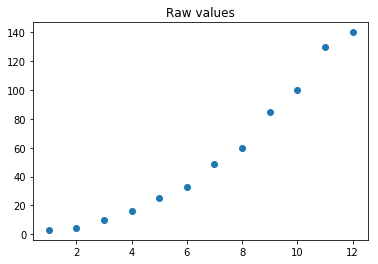

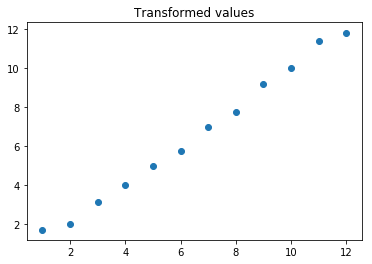

In [4]:
# Sample data.
outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
feature = [3, 4, 10, 16, 25, 33, 49, 60, 85, 100, 130, 140]

# Plot the data as-is. Looks a mite quadratic.
plt.scatter(outcome, feature)
plt.title('Raw values')
plt.show()

# Create a feature using a non-linear transformation.
sqrt_feature = [math.sqrt(x) for x in  feature]


# Well now isn't that nice.
plt.scatter(outcome, sqrt_feature)
plt.title('Transformed values')
plt.show()

### Assumption two: multivariate normality

Error from the model should be normally distributed.

Calculate error: subtract the model-predicted values from the real outcome values

Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

Outliers or skewness in error can often be traced back to outliers or skewness in data.

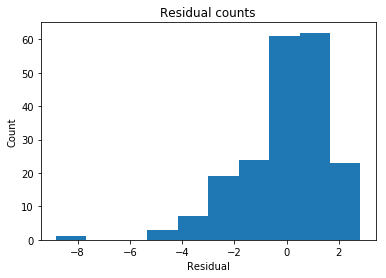

In [5]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning. Left skewed (based on tail)
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### Assumption three: homoscedasticity

scedasticity = The distribution of your error

homoscedastic = the distribution of all predicted values are consistent

heteroscedasticity - the distribution of predicted values vary

Large predicted values will be too small when error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones.  This happens because confidence interval will be based on the average error variance.

This leads to overconfidence in the accuracy of your model's predictions.

Fix heteroscedasticity:  transform the dependent variable and add features that target the poorly-estimated areas.

For example, if a model tracks data over time and model error variance jumps in the September to November period, a binary feature indicating season may be enough to resolve the problem.

You want the errors to be modeling something on their own.

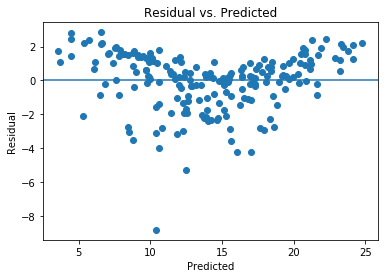

In [6]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

### Assumption four: low multicollinearity

Correlations among features should be low or nonexistent.

When features are correlated, they may both explain the same pattern of variance in the outcome.  The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other.

#### High multicollinearity:

Problem: if we want to know which features matter most when predicting an outcome, multicollinearity can cause us to underestimate the relationship between features and outcomes.

Not a problem: when our only goal is prediction because all that matters is that variance gets explained.

To fix: use PCA or discard some of the correlated features.

In [7]:
correlation_matrix = X.corr()
display(correlation_matrix)

,TV,Radio,Newspaper
TV,1.000,0.055,0.057
Radio,0.055,1.000,0.354
Newspaper,0.057,0.354,1.000


## Drill: fix assumptions

Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality.  Use the cell(s) below to see what you can do to fix it.


In [8]:
data.columns

Index(['Unnamed: 0', 'TV', 'Radio', 'Newspaper', 'Sales'], dtype='object')

#### Graphical Plots of dependent and independent variables

##### Given that Newspaper independent variable does not appear to have a strong linear relationship with Sales, will remove.  Also, coefficient for Newspaper variable in OLS below is negative, indicating a negative relationship with Sales.

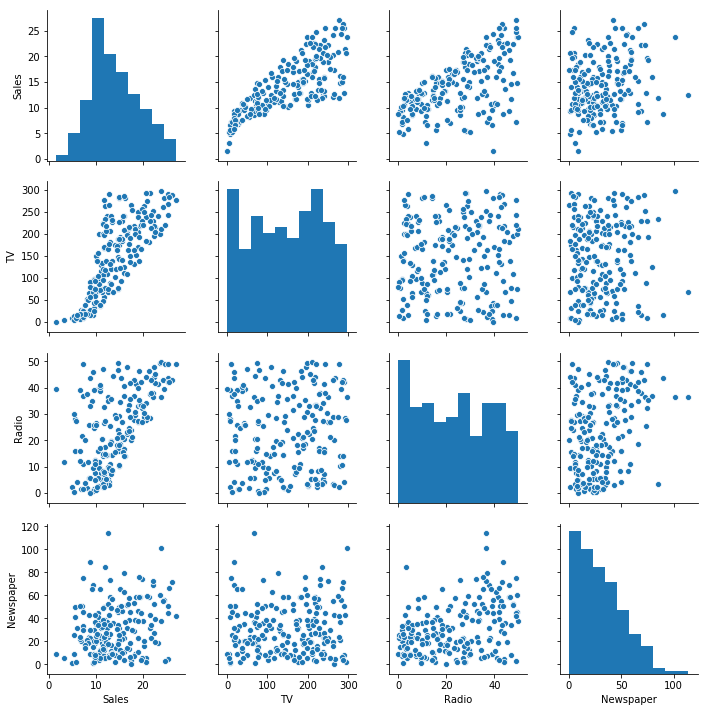

In [9]:
sns.pairplot(data[['Sales', 'TV', 'Radio', 'Newspaper']].dropna(how = 'any', axis = 0))
plt.show()

#### Ordinary Least Squares

In [10]:
# Ordinary Least Squares formula - dependent variable comes before the "~", then each independent variable
# https://stackoverflow.com/questions/30650257/ols-using-statsmodel-formula-api-versus-statsmodel-api
# http://songhuiming.github.io/pages/2016/12/31/linear-regression-in-python-chapter-2/

lm_all_1 = smf.ols(formula = "Sales ~ TV + Radio + Newspaper", data = data).fit()
lm_all_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 01 Nov 2018   Prob (F-statistic):           1.58e-96
Time:                        21:21:12   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Update - What I learned...the process:
    
#### Homescedasticity: Check residuals scatter plot.   Sscedasticity (distribution of error) as diagnostic - the more spread out (without a coherent pattern), the better.  Indication that additional feature engineering needs to occur.

#### Multivariate Normality: Check that dependent variable follows normalish distribution (as compared to theoretical normal distribution) - and apply transformations (log, sqrt, inverse, box cox, absolute value, PCA, etc) to get it to be more normal.  Handle missing values, null values, potential outliers.

#### Linearity: Check that independent variables have a linear relationship (diagonal horizontal line) with dependent variable.  Transform them as necessary.  Can remove any independent variables that don't have a linear relationship. Handle missing values, null values, potential outliers.

#### Multicollinearity: Check that independent variables do not share responsibility for outcome - multicollinearity - otherwise, the redundant independent variables can be removed.

### Previous mistakes: 
#### Attempted to apply the transformation directly to the error - looking at residuals is just another diagnostic tool to know that you need to go back to model to do feature engineering needs.  Don't mess with transforming the residuals.

#### Kept trying to transform independent variables so they would follow a normal distribution.  They just need to show linearity: there is a linear relationship with dependent variable (subplots identify well)

### Check for Heteroscedasticity:

#### Residuals Scatter Plot - Test for Heteroscedascity:

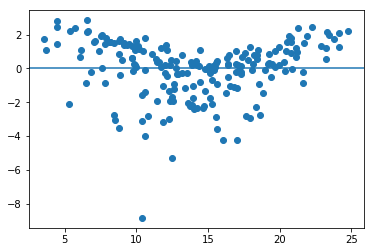

In [993]:
resid_1 = lm_all_1.resid
plt.axhline(y=0)
plt.scatter(lm_all_1.predict(), resid_1);

#### Will look at dependent variable data['Sales'] first:
https://statswithcats.wordpress.com/2010/11/21/fifty-ways-to-fix-your-data/

In [11]:
data['Sales'].head()

0   22.100
1   10.400
2    9.300
3   18.500
4   12.900
Name: Sales, dtype: float64

### Mentor meeting:

mean = 14.023
median = 12.9

Mean and median look pretty "normal" without transformation since they are so close.  Will still do transformations and then complete Shapiro Test.  Box Cox transformation of dependent variable made it most "normal".

In [13]:
# Mean and Median (50%) are close -  
data['Sales'].describe()


count   200.000
mean     14.023
std       5.217
min       1.600
25%      10.375
50%      12.900
75%      17.400
max      27.000
Name: Sales, dtype: float64

### Dependent Variable Sales subplots with raw, log, square root, and box cox transformations

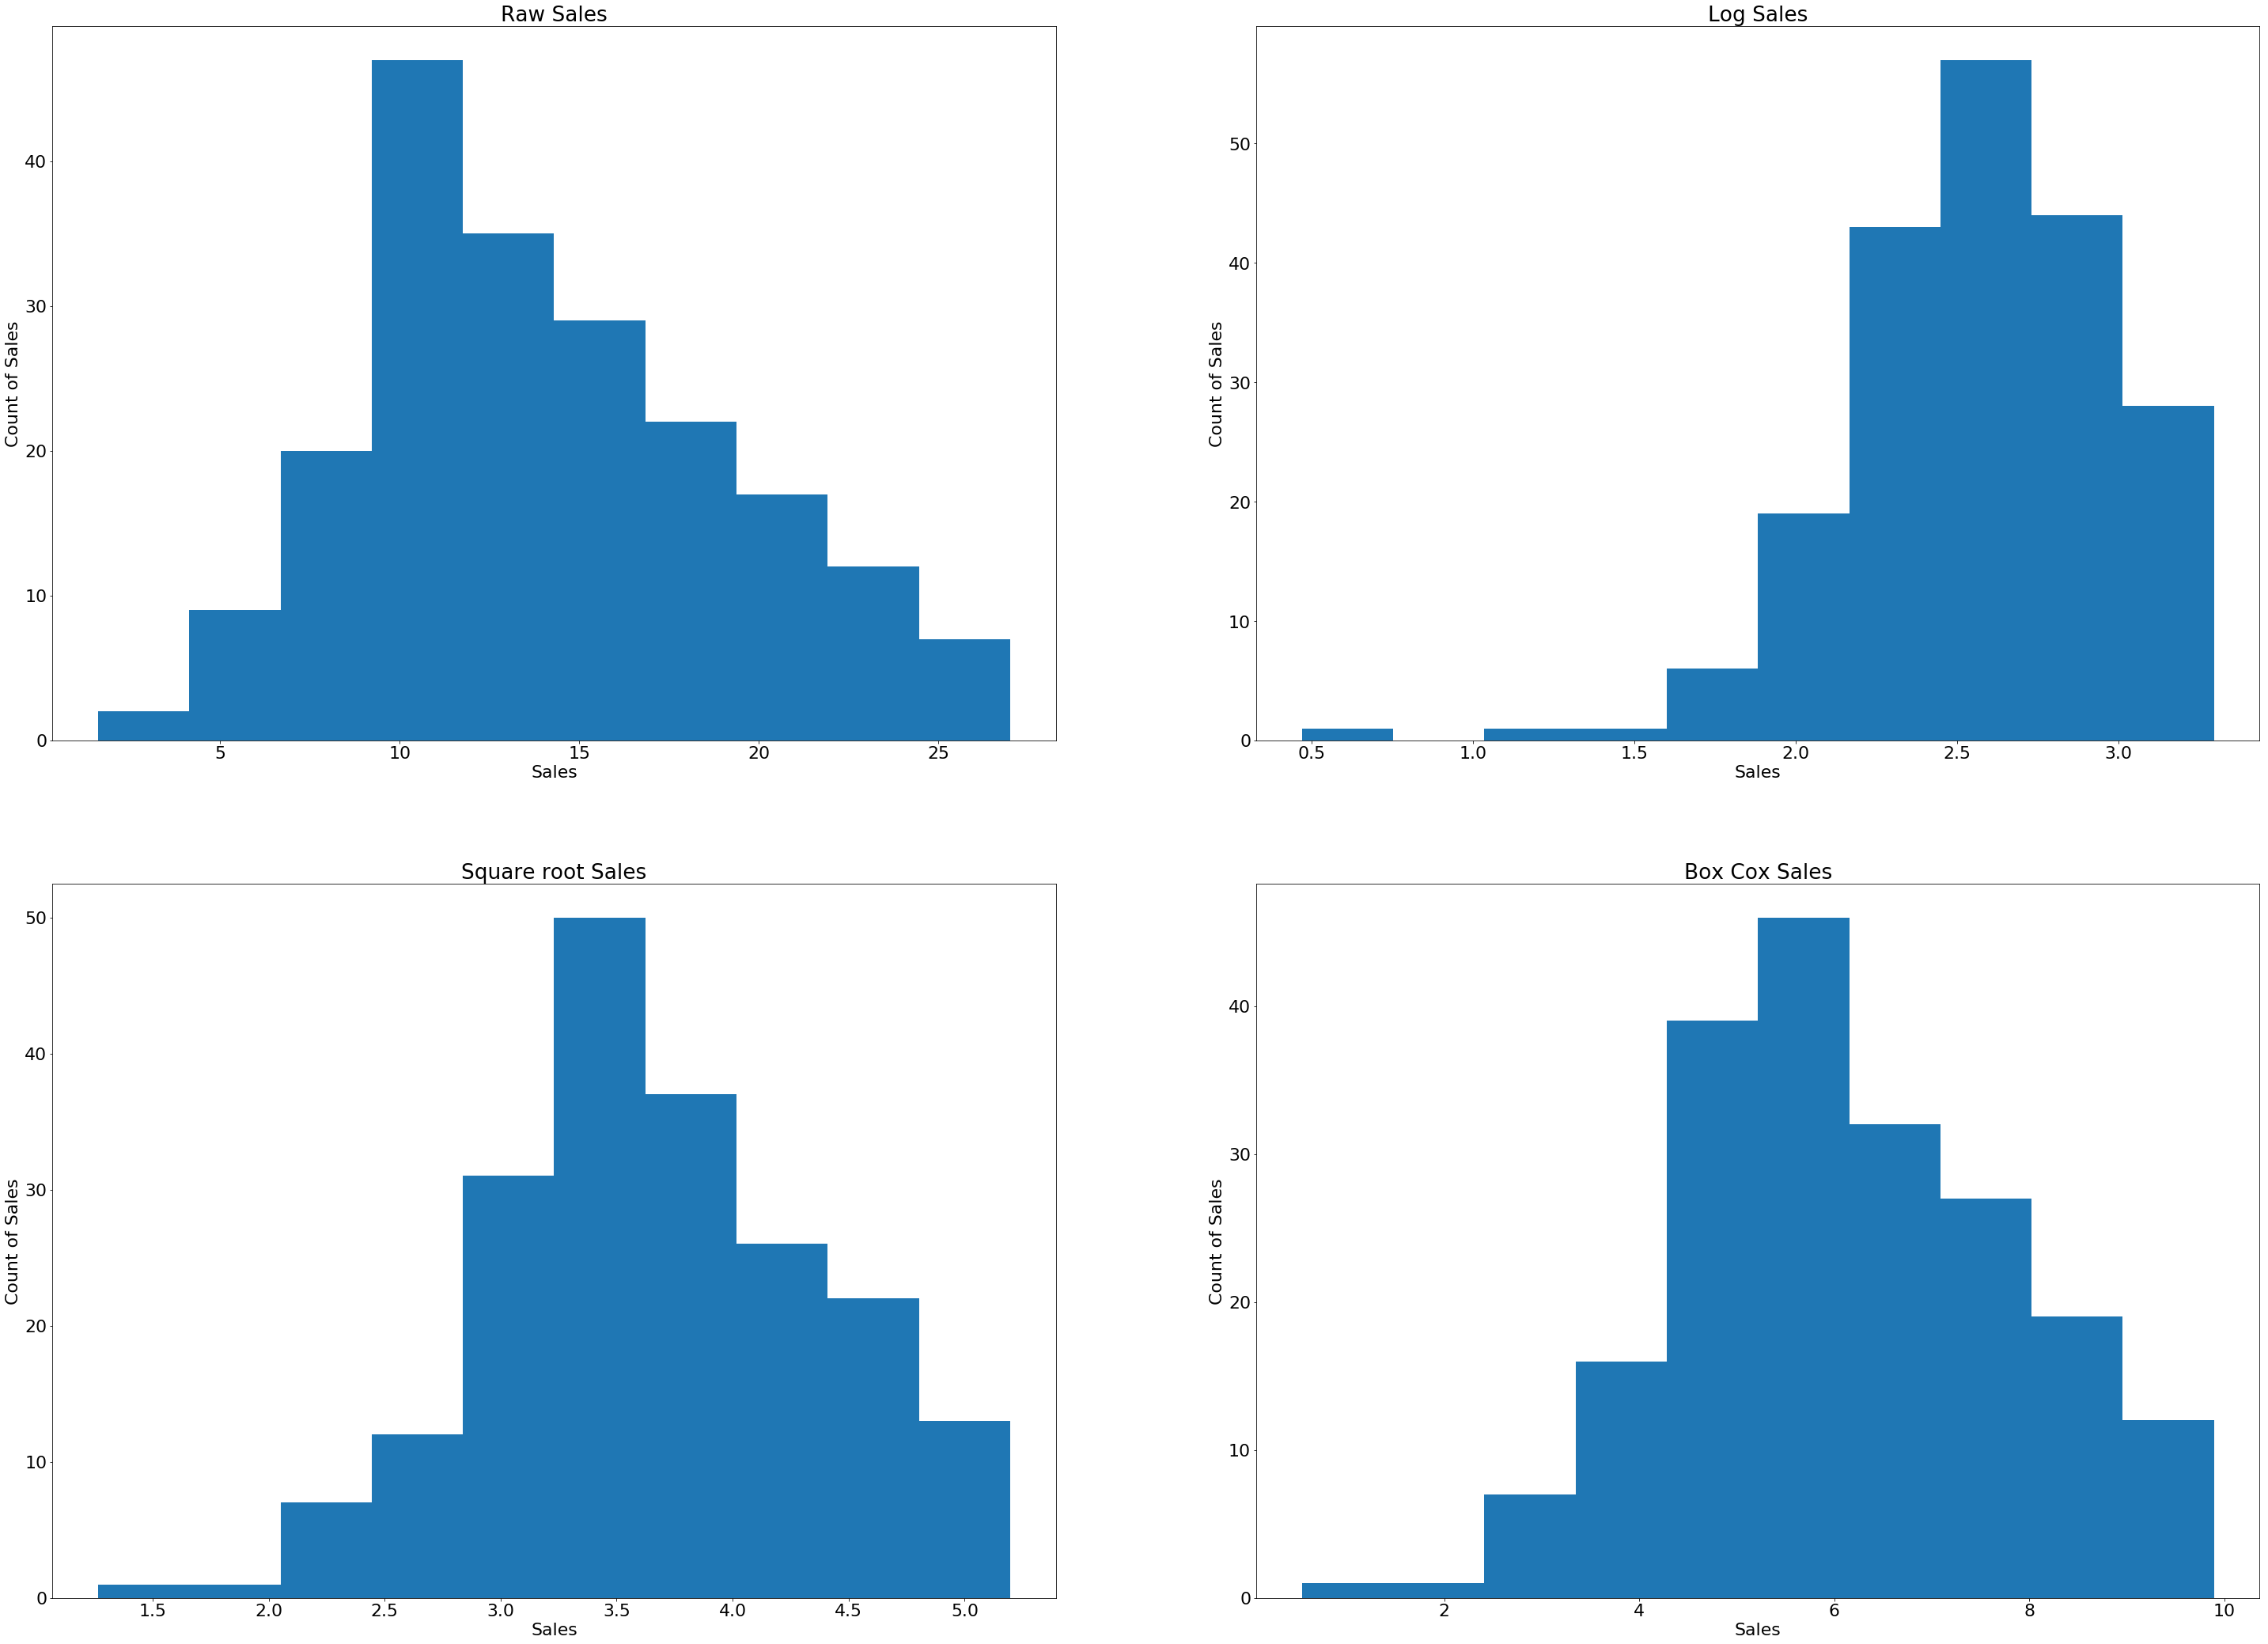

In [20]:
# Checking out the distribution of the independent variable: TV
fig = plt.figure()
plt.subplots_adjust(left=None, bottom=-.5, right=None, top=None, wspace=None, hspace=None)

fig.add_subplot(221)
plt.hist(data['Sales'])
plt.title('Raw Sales')
plt.xlabel('Sales')
plt.ylabel('Count of Sales')

fig.add_subplot(222)
plt.hist(np.log(data['Sales']))
plt.title('Log Sales')
plt.xlabel('Sales')
plt.ylabel('Count of Sales')

fig.add_subplot(223)
plt.hist(np.sqrt(data['Sales'].replace(0, np.nan).dropna()))
plt.title('Square root Sales')
plt.xlabel('Sales')
plt.ylabel('Count of Sales')

ax3=fig.add_subplot(224)
# Box Cox Transformation:
# http://www.kmdatascience.com/2017/07/box-cox-transformations-in-python.html

transform_sales = np.asarray(data[['Sales']].values)

# transform values and store as "boxcox_sales"
boxcox_sales = boxcox(transform_sales)[0]

# create the boxcox_sales transformed variable:
data['boxcox_sales'] = boxcox_sales

# plot the transformed box cox data
plt.hist(boxcox_sales)
plt.title('Box Cox Sales')
plt.xlabel('Sales')
plt.ylabel('Count of Sales')

plt.show()


In [24]:
print('Shapiro Test for Sales (Dependent Variable):')
print()
print('Log:         ', scipystats.shapiro(np.log(data['Sales'])))
print('Square Root: ', scipystats.shapiro(np.sqrt(data['Sales'])))
print('Box Cox:     ', scipystats.shapiro(data['boxcox_sales']))
print()
print('The Box Cox Transformation is the most normal of the three (largest W statistic/score)')
print()
print('First number = W statistic. Want one with highest W.')
print()
print('Second number = p-value. Want p-value > .05 (otherwise, indicates a significant difference)')

Shapiro Test for Sales (Dependent Variable):

Log:          (0.9519966244697571, 2.953277544293087e-06)
Square Root:  (0.9888856410980225, 0.12231794744729996)
Box Cox:      (0.9892246723175049, 0.13737188279628754)

The Box Cox Transformation is the most normal of the three (largest W statistic/score)

First number = W statistic. Want one with highest W.

Second number = p-value. Want p-value > .05 (otherwise, indicates a significant difference)


### Dependent Variable Sales is now as normal as it'll get as boxcox_sales.
### Recheck error residuals
### Heteroscedasticity is improved, but outliers may affect error resideuals - will remove outlying data points and recheck residuals

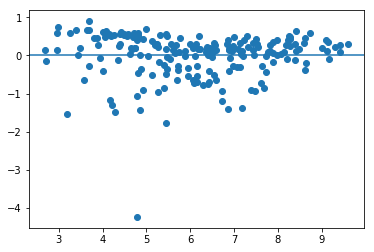

In [29]:
lm_2 = smf.ols(formula = "boxcox_sales ~ TV + Radio", data = data).fit()

resid_2 = lm_2.resid
plt.axhline(y=0)
plt.scatter(lm_2.predict(), resid_2);

#### TV's min value is a lot lower than it's next bigger value.  Radio's min value is 0.  Will remove the smallest values by percentage cutoff of .5% to clip only the smallest numbers.

#### The largest values of both independent variables TV and Radio appear to be somewhat similar.

In [1007]:
print('TV data describe:')
print(data['TV'].describe())
print()

print('Radio data describe:')
print(data['Radio'].describe())

TV data describe:
count   200.000
mean    147.042
std      85.854
min       0.700
25%      74.375
50%     149.750
75%     218.825
max     296.400
Name: TV, dtype: float64

Radio data describe:
count   200.000
mean     23.264
std      14.847
min       0.000
25%       9.975
50%      22.900
75%      36.525
max      49.600
Name: Radio, dtype: float64


In [30]:
print('Smallest 5 TV values:')
print(data['TV'].nsmallest(5))
print()
print('Largest 5 TV values:')
print(data['TV'].nlargest(5))

print()
print('Smallest 5 Radio values:')
print(data['Radio'].nsmallest(5))
print()
print('Largest 5 Radio values:')
print(data['Radio'].nlargest(5))

Smallest 5 TV values:
130   0.700
155   4.100
78    5.400
56    7.300
126   7.800
Name: TV, dtype: float64

Largest 5 TV values:
101   296.400
42    293.600
30    292.900
35    290.700
98    289.700
Name: TV, dtype: float64

Smallest 5 Radio values:
127   0.000
107   0.300
108   0.400
117   0.800
157   1.300
Name: Radio, dtype: float64

Largest 5 Radio values:
58    49.600
37    49.400
55    49.400
128   49.000
147   49.000
Name: Radio, dtype: float64


In [47]:
# Create variables to remove outliers in independent variables: remove all values below the .5% of values in that column 
tv_min = data[(data['TV'] < np.percentile(data['TV'],.5))]
radio_min = data[(data['Radio'] < np.percentile(data['Radio'],.5))]


In [48]:
# Remove min from TV and Radio
data = data.replace(0, np.nan).dropna()
data = data.replace(tv_min, np.nan).dropna()
data = data.replace(radio_min, np.nan).dropna()

# get minimum value row for TV
print('TV min:')
print(data.loc[data['TV'].idxmin()])
print()
print('Radio min:')
print(data.loc[data['Radio'].idxmin()])

# drop min values for features


TV min:
Unnamed: 0     38.000
TV             74.700
Radio          49.400
Newspaper      45.700
Sales          14.700
boxcox_sales    6.449
Name: 37, dtype: float64

Radio min:
Unnamed: 0     111.000
TV             225.800
Radio            8.200
Newspaper       56.500
Sales           13.400
boxcox_sales     6.023
Name: 110, dtype: float64


### Recheck error residuals
#### Homoscedasticity is improved
#### Explore if transformation of independent variables can improve homoscedasticity further

                            OLS Regression Results                            
Dep. Variable:           boxcox_sales   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1106.
Date:                Thu, 01 Nov 2018   Prob (F-statistic):           4.32e-63
Time:                        22:21:32   Log-Likelihood:                 5.2168
No. Observations:                  91   AIC:                            -4.434
Df Residuals:                      88   BIC:                             3.099
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7591      0.102     27.172      0.0

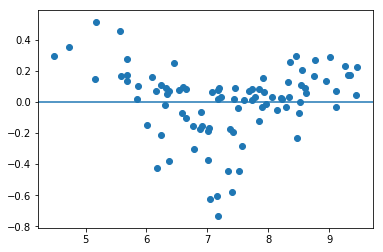

In [60]:
lm_3 = smf.ols(formula = "boxcox_sales ~ TV + Radio", data = data).fit()
print(lm_3.summary())

resid_3 = lm_3.resid
plt.axhline(y=0)
plt.scatter(lm_3.predict(), resid_3);

### Applied transformations to independent variables to determine if transformations would improve linearity.  They don't.

#### TV:

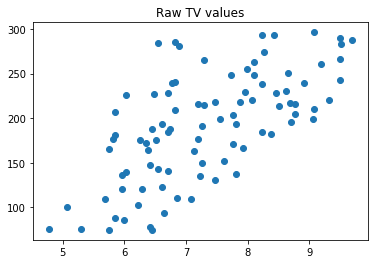

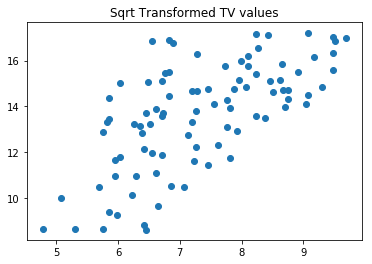

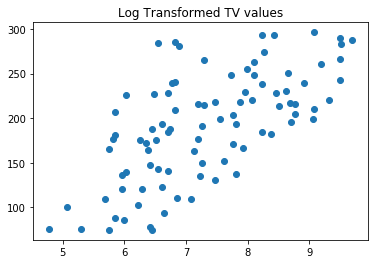

In [52]:
# Look at linearity: relationship of independent variable TV transformed to dependent variable Sales

# Sample data.
outcome_tv = data['boxcox_sales']
feature_tv = data['TV']
#feature_log = data['Radio'].replace(0, np.nan).dropna()

# Plot the Raw TV Values.
plt.scatter(outcome_tv, feature_tv)
plt.title('Raw TV values')
plt.show()

# Create a Square Root feature using a non-linear transformation.
sqrt_feature_tv = [math.sqrt(x) for x in feature_tv]


# Square Root TV feature
plt.scatter(outcome_tv, sqrt_feature_tv)
plt.title('Sqrt Transformed TV values')
plt.show()

# Create a Log feature using a non-linear transformation.
feature_log = [math.log(x) for x in feature_tv.replace(0, np.nan).dropna()]

# Log TV Feature
plt.scatter(outcome_tv, feature_tv)
plt.title('Log Transformed TV values')
plt.show()


#### Radio:

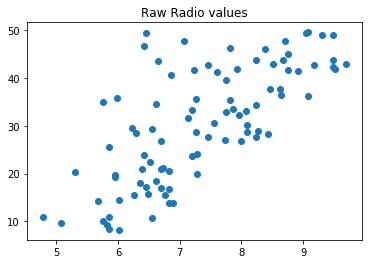

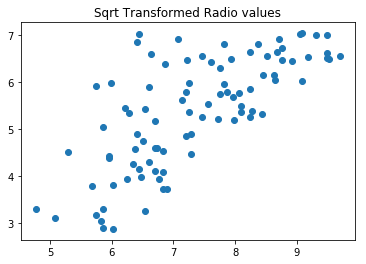

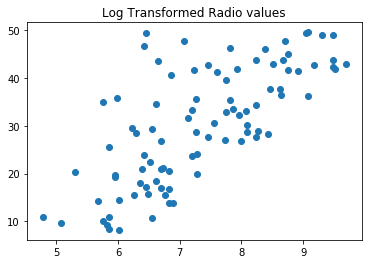

In [55]:
# Look at linearity: relationship of independent variable TV transformed to dependent variable Sales

# Sample data.
outcome_radio = data['boxcox_sales']
feature_radio = data['Radio']

# Plot the Raw TV Values.
plt.scatter(outcome_radio, feature_radio)
plt.title('Raw Radio values')
plt.show()

# Create a Square Root feature using a non-linear transformation.
sqrt_feature_radio = [math.sqrt(x) for x in feature_radio]


# Square Root TV feature
plt.scatter(outcome_radio, sqrt_feature_radio)
plt.title('Sqrt Transformed Radio values')
plt.show()

# Create a Log feature using a non-linear transformation.
feature_log = [math.log(x) for x in feature_radio.replace(0, np.nan).dropna()]

# Log TV Feature
plt.scatter(outcome_radio, feature_radio)
plt.title('Log Transformed Radio values')
plt.show()


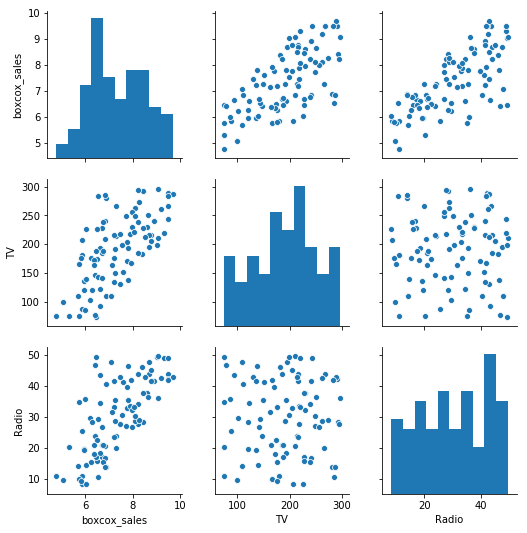

In [61]:
sns.pairplot(data[['boxcox_sales', 'TV', 'Radio']].dropna(how = 'any', axis = 0))
plt.show()